# Generating mutation scrambles of different sizes.

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [1]:
import wgregseq
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt


# Set default plotting style
wgregseq.plotting_style()
%matplotlib inline

In this notebook we explore how to generate scrambles given a certain sequence. We want to be able to do it for sequences of various lengths, with variable size of the scrambles and variable overlap of consecutive scrambles. This method is based of the work from [Urtecho et al., 2020](https://www.biorxiv.org/content/10.1101/2020.01.04.894907v1), where they used scrambles of size 10, with an overlap of 5 base pairs. To find scrambles which are distant from the wild type sequence, they generated 100 scrambles by permuting the original sequence, and chose the sequence which was most distant. This preserves the GC-content of the sequence.

Let's generate a random sequence to begin with. Therefore we can use the function `wgregseq.gen_rand_seq()`, which takes the sequence length as an argument. One can also give a list of letters as second argument. By default, a random DNA sequence is generated.

In [2]:
sequence = wgregseq.gen_rand_seq(20.)
sequence

'CTTCCGAAAGCCGAACGGAC'

To generate scrambles, we can use the function `wgregseq.create_scrambles()`, which takes as arguments the wild type sequence, the length of the generated scrambles, the number of overlapping bases, and the number of sequences generated per scramble, from which the most distant is chosen. The function will return an error message, if it cannot generate scrambles evenly throughout the sequence.

In [3]:
wgregseq.create_scrambles(sequence, 10, 6, 100, ignore_imperfect_scrambling=True)

/Users/tomroschinger/git/Reg-Seq2/software_module/wgregseq/seq_utils.py:170: UserWarning: Imperfect scrambles. Last scramble is omitted.
  warnings.warn("Imperfect scrambles. Last scramble is omitted.")


array(['CTTCCGAAAGCCGAACGGAC', 'AACTGTCCGACCGAACGGAC',
       'CTTCGCCGCAAAAGACGGAC', 'CTTCCGAAGCGAAGCGCAAC'], dtype='<U160')

The scrambles can also be returned in a data frame, which also includes the start and stop positions of the scrambles, as well as the center position. Note that here the wild type is not included.

In [4]:
df = wgregseq.create_scrambles_df(sequence, 10, 5, 100)
df

,start_pos,stop_pos,sequence,center_pos
0,0,10,AGCTACTCGACCGAACGGAC,5.0
1,5,15,CTTCCAAGGAAACCGCGGAC,10.0
2,10,20,CTTCCGAAAGGCCCGACAGA,15.0


## Scan scrambles

In [5]:
sequence_df = pd.read_csv("../../data/RegSeq/wtsequences.csv", index_col=0).reset_index()
sequence = sequence_df.loc[sequence_df["name"] == "ykgE", "geneseq"].values[0]
sequence

'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [6]:
effect_matrix = pd.read_csv("../../data/RegSeq/ykgEarabinosedataset_alldone_with_largeMCMC194", delim_whitespace=True)
effect_matrix.rename(columns={"val_A":"A", "val_C":"C", "val_G":"G", "val_T":"T"}, inplace=True)
effect_matrix

,pos,A,C,G,T
0,0,0.014540,0.001685,-0.022539,0.006314
1,1,0.023509,-0.002869,-0.023115,0.002475
2,2,-0.003412,0.020748,-0.016885,-0.000451
3,3,0.009721,-0.001487,-0.020443,0.012209
4,4,-0.011957,-0.000411,0.021063,-0.008694
...,...,...,...,...,...
175,175,-0.003142,-0.006916,0.004624,0.005434
176,176,-0.006274,0.013448,0.010144,-0.017318
177,177,-0.000617,0.003695,0.005405,-0.008484
178,178,0.005982,-0.002930,0.008917,-0.011969


In [49]:
df = wgregseq.create_scrambles_df(sequence, 10, 6, 100,  ignore_imperfect_scrambling=True)
df.head()

/Users/tomroschinger/git/Reg-Seq2/software_module/wgregseq/seq_utils.py:173: UserWarning: Imperfect scrambles. Last scramble is omitted.
  warnings.warn("Imperfect scrambles. Last scramble is omitted.")


,start_pos,stop_pos,sequence,center_pos
0,0,10,CTCTGCCTATCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
1,4,14,TCGACCCTATTTACAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,9.0
2,8,18,TCGATTTCAAATACCCTAGTGAGCGATGCCGAAAGAAATAAAATTA...,13.0
3,12,22,TCGATTTCCCCAAGTTGAAAATGCGATGCCGAAAGAAATAAAATTA...,17.0
4,16,26,TCGATTTCCCCATAAACGAGAGTATGTGCCGAAAGAAATAAAATTA...,21.0


In [50]:
eff_df = wgregseq.sum_emat_df(df, effect_matrix)

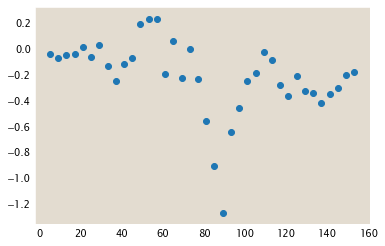

In [51]:
x = eff_df["center_pos"].unique()
y = eff_df.groupby("center_pos")["effect"].mean().values
plt.scatter(x, y)

In [52]:
sequence

'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

In [53]:
mutants = wgregseq.mutations_det(sequence, mut_per_seq=2, site_start=0, site_end=5)

In [56]:
wgregseq.add_primers(df["sequence"].values, 0)

array(['ATATAGATGCCGTCCTAGCGCTCTGCCTATCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGGAAGTATCTTTCCTGTGCCCA',
       'ATATAGATGCCGTCCTAGCGTCGACCCTATTTACAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGGAAGTATCTTTCCTGTGCCCA',
       'ATATAGATGCCGTCCTAGCGTCGATTTCAAATACCCTAGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGGAAGTATCTTTCCTGTGCCCA',
       'ATATAGATGCCGTCCTAGCGTCGATTTCCCCAAGTTGAAAATGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGGAAGTATCTTTCCTGTGCCCA',
       'ATATAGATGCCGTCCTAGCGTCGATTTCCCCATAAACGAGAGTATGTGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAG

These sequences including scrambles can be used to identify transcription factor binding sites or RNAP binding sites.

## Computing Environment

In [ ]:
%load_ext watermark
%watermark -v -p wgregseq,numpy,pandas